In [1]:
from integsol.mesh.mesh import Mesh
from integsol.compute.vectors import VectorField
from integsol.compute.operators import (
    IntegralConvolutionOperator as ICO,
    CrossProductOperator as CPO,
)
from integsol.validators.compute_validators import *
from integsol.compute.kernels import demagnetization_tensor_kernel as dtk
import numpy as np
from torch.linalg import eig
from torch import (
    Tensor,
    dot,
    matmul,
    mv,
)


In [2]:
M_s = 1.45 * 1e4
gamms = 2.25 * 1e4

In [3]:
mesh = Mesh.read(path="/home/aluatar/integsol/test_inputs/sphere_r=300_mesh_100nm.mphtxt")
#mesh_2 = Mesh.read(path="/home/aluatar/integsol/test_inputs/mesh_coerser.mphtxt")

Begin calculation of elements measures.
Calculate measures for vtx type of elements
Calculate measures for edg type of elements
Progress: 98.33%

Calculate measures for tri type of elements
Progress: 99.71%

Calculate measures for tet type of elements
Progress: 99.95%

Calculation of measures of all elements finished in 9.919222354888916 seconds.


In [4]:
centers = mesh.elements_centers['tet'].T
nodes = mesh.coordinates.T
elements = mesh.elements_coordinates
len(centers.T)

1882

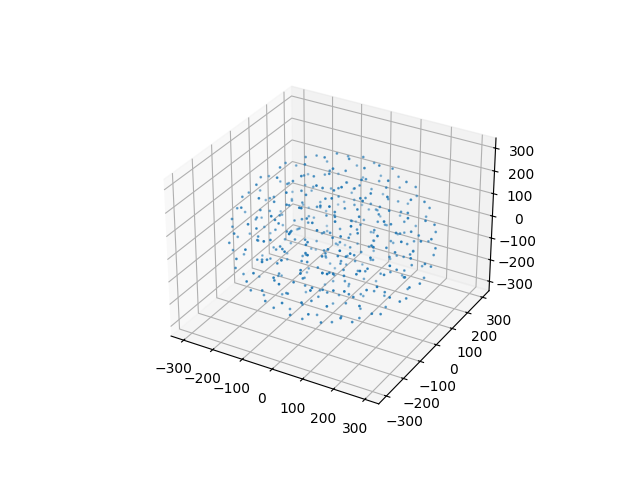

In [5]:
%matplotlib widget
import matplotlib.pyplot as plt 
import numpy as np

fig = plt.figure()

ax = fig.add_subplot(projection='3d')

ax.scatter(xs=np.float64(nodes[0]), ys=np.float64(nodes[1]), zs=np.float64(nodes[2]), s=1)
#ax.scatter(xs=mesh.coordinates[Hd_nodes_nans][0], ys=mesh.coordinates[Hd_nodes_nans][1], zs=mesh.coordinates[Hd_nodes_nans][2], color='red')

In [6]:
coord_to_write = []
X, Y, Z =[], [], []
for coordinate in centers.T:
    X.append(coordinate[0])
    Y.append(coordinate[1])
    Z.append(coordinate[2])

coord_to_write = zip(X,Y,Z)

from datetime import datetime
import csv

with open(F"/home/aluatar/integsol/outputs/interpolation_coordinates/coordinates_{datetime.now()}.txt", 'w') as _csv:
    writer = csv.writer(_csv, delimiter='\t')
    writer.writerows(coord_to_write)

In [7]:
M0 = VectorField.read_to_mesh(
    path="/home/aluatar/integsol/test_inputs/sphere_r=300_magnetization_100nm.txt",
    mesh=mesh,
    dim=3)

In [8]:
M0_cpo = CPO(
    mesh=mesh,
    left_vector= M0
)

M0_times_ = M0_cpo.to_mesh_matrix()
M0_times_
del M0

Begin placement of operator on mesh elements' centers.
Progress: 99.95%

Mesh matric of the operator generated in 2.7769622802734375 seconds.


In [9]:
ico = ICO(kernel=dtk)
int_G_ = ico.to_mesh_matrix(mesh=mesh)

Begin placement of operator on mesh elements' centers.
Progress: 99.95%

Mesh matric of the operator generated in 346.13531255722046 seconds.


In [10]:
H_eff = VectorField.read_to_mesh(
    path="/home/aluatar/integsol/test_inputs/sphere_r=300_H_eff_100nm.txt",
    mesh=mesh,
    dim=3)

"""_H_eff = H_eff.vectorize()
vals_H_eff = H_eff.values.T"""

'_H_eff = H_eff.vectorize()\nvals_H_eff = H_eff.values.T'

In [13]:
"""%matplotlib inline
%matplotlib widget 

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(projection="3d") 

ax.quiver(
    centers[0],
    centers[1],
    centers[2],
    vals_H_eff[0],
    vals_H_eff[1],
    vals_H_eff[2],
    length=0.001,
)

plt.show()"""

h_mx = np.max([np.dot(e,e) for e in H_eff.values])
h_mx

np.float64(2310218146.0012217)

In [14]:
H_eff_cpo = CPO(
    mesh=mesh,
    left_vector=H_eff
)
H_eff_times_ = H_eff_cpo.to_mesh_matrix()
del H_eff

Begin placement of operator on mesh elements' centers.
Progress: 99.95%

Mesh matric of the operator generated in 3.180363655090332 seconds.


In [53]:
IntConvOp = matmul(M0_times_,int_G_)

In [54]:
LLG_operator = gamms * (H_eff_times_ / M_s - IntConvOp)

del IntConvOp
LLG_operator

tensor([[ 8.6913e+03,  9.5328e+04,  3.0321e+04,  ...,  5.9198e+00,
          3.6014e+01,  6.9670e-01],
        [-8.8691e+04, -8.6911e+03, -3.1563e+04,  ...,  7.1194e+01,
         -5.9212e+00,  1.1729e+01],
        [ 2.4008e+01,  2.1369e+01, -1.9749e-01,  ...,  8.4978e-03,
          3.2435e-03,  1.3699e-03],
        ...,
        [ 6.2967e+00,  4.1002e+01,  7.2138e-01,  ...,  1.8637e+03,
          1.0366e+05,  3.9082e+04],
        [ 8.1075e+01, -6.2967e+00,  1.2954e+01,  ..., -8.4562e+04,
         -1.8626e+03, -4.4334e+04],
        [ 4.0040e-04, -8.6531e-04,  6.9696e-05,  ..., -1.2643e+02,
         -3.6821e+02, -1.0738e+00]])

In [55]:
omega_char = gamms * h_mx
null_LLG = LLG_operator + 1j * omega_char * np.identity(n=len(LLG_operator))
null_LLG

U, S, Vh = np.linalg.svd(null_LLG)


/tmp/ipykernel_28961/1048288252.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  null_LLG = LLG_operator + 1j * omega_char * np.identity(n=len(LLG_operator))


: 

In [33]:
null_space = np.compress(S <= 5.2e13, Vh, axis=0)
null_space.T

tensor([[-8.0910e-04+0.0000e+00j,  2.0992e-03+0.0000e+00j,
         -1.5904e-03+0.0000e+00j,  ...,
         -1.5932e-03+0.0000e+00j,  2.0981e-03+0.0000e+00j,
         -8.0876e-04+0.0000e+00j],
        [-7.2532e-04+2.5489e-03j, -5.3305e-04-8.8556e-04j,
          1.0396e-03+1.8645e-03j,  ...,
          1.0403e-03-1.8649e-03j, -5.3122e-04+8.8549e-04j,
         -7.2618e-04-2.5485e-03j],
        [-1.6641e-03-3.6519e-04j, -4.5961e-04-2.6464e-03j,
         -4.6784e-04-8.2593e-05j,  ...,
         -4.6835e-04+8.0480e-05j, -4.5874e-04+2.6479e-03j,
         -1.6643e-03+3.6569e-04j],
        ...,
        [-5.5656e-04-3.1620e-04j, -2.4611e-03-7.6424e-04j,
          1.4347e-03+7.8912e-05j,  ...,
          1.4372e-03-7.9712e-05j, -2.4605e-03+7.6743e-04j,
         -5.5682e-04+3.1672e-04j],
        [-1.2575e-05+2.0069e-04j,  5.2149e-04+1.4685e-04j,
         -3.6368e-04+8.0246e-04j,  ...,
         -3.6260e-04-8.0271e-04j,  5.2182e-04-1.4901e-04j,
         -1.2409e-05-2.0109e-04j],
        [ 5.7573e-07+2

In [46]:
from scipy.sparse.linalg import eigs as speigs

eigs = speigs(np.array(LLG_operator), k=15, tol=1e-15, v0=null_space.T[-1])

/tmp/ipykernel_28961/3866341659.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  eigs = speigs(np.array(LLG_operator), k=15, tol=1e-15, v0=null_space.T[-1])


In [47]:
eigs

(array([-3.81469727e-06-7.56274869e+09j,  5.17815351e-06+7.56106516e+09j,
         8.58841790e-07-7.33142993e+09j, -5.76245998e-06+7.35787639e+09j,
         1.18096739e-05-7.07320354e+09j, -8.26794623e-06+7.11336580e+09j,
        -6.97283104e-06-6.83427394e+09j, -2.05923129e-05-6.68874694e+09j,
        -1.84035132e-06+6.78407881e+09j,  4.24729100e-06+6.67937041e+09j,
        -5.23520572e-06-6.31685822e+09j,  8.28870910e+07-6.27274122e+09j,
        -8.28870910e+07-6.27274122e+09j,  7.49226556e+07+6.32216392e+09j,
        -7.49226556e+07+6.32216392e+09j]),
 array([[-1.98489266e-03+1.35323613e-04j,  3.23039456e-03-1.97362466e-03j,
         -8.42146025e-05-7.43810140e-05j, ...,
         -1.03800182e-03+1.84244392e-03j, -3.90696208e-03+4.96426884e-03j,
         -5.49745106e-03-3.11229010e-03j],
        [-5.43940005e-03+3.70840843e-04j, -4.27862144e-03+2.61404377e-03j,
         -6.89778396e-04-6.09234207e-04j, ...,
          1.99665301e-03+5.02827520e-03j,  5.33419965e-03-7.23928669e-03j,
  

In [48]:
eigenvalues = eigs[0]#.eigenvalues
eigenvectors = eigs[1].T#.eigenvectors.T
eigenvalues = (1j * np.array(eigenvalues))
eigenvalues_idx = np.where(abs(eigenvalues.imag) < 10000000)[0]
eigenvalues = eigenvalues[eigenvalues_idx].real
eigenvalues_idx = np.where(abs(eigenvalues) > 1e9)[0]
eigenvalues = eigenvalues[eigenvalues_idx]
eigenvalues, eigenvalues_idx

(array([ 7.56274869e+09, -7.56106516e+09,  7.33142993e+09, -7.35787639e+09,
         7.07320354e+09, -7.11336580e+09,  6.83427394e+09,  6.68874694e+09,
        -6.78407881e+09, -6.67937041e+09,  6.31685822e+09]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

In [51]:
dm = VectorField(
    mesh=mesh,
    coordinates=mesh.elements_centers['tet'],
)
n = 1
_dm = eigenvectors[0] #+ eigenvectors[1]
dm.devectorize(np.array(_dm).real)

dm_values = dm.values.T
dm_coordinates = dm.coorrdinates.T

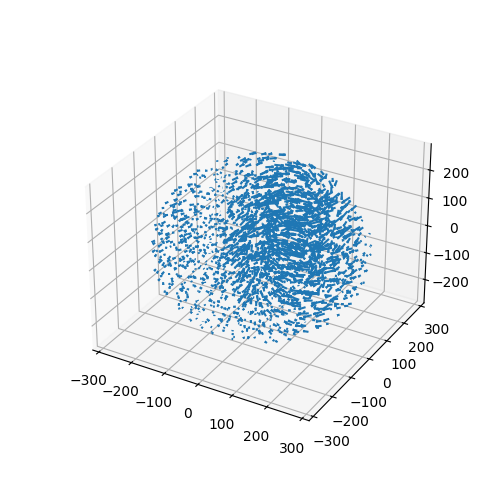

In [52]:
%matplotlib inline
%matplotlib widget 

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(projection="3d") 

ax.quiver(
    dm_coordinates[0],
    dm_coordinates[1],
    dm_coordinates[2],
    dm_values[0],
    dm_values[1],
    dm_values[2],
    length=900,
)

plt.show()

In [ ]:
eigenvalues[0]

In [ ]:
5e5 * gamms